<a href="https://colab.research.google.com/github/umbutun/hands-on-machine-learning-practice/blob/main/notebooks/chapter_05_decision_trees/chapter_05_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 5 – Decision Trees**

_This notebook contains all the sample code and solutions to the exercises in chapter 5._

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

It also requires Scikit-Learn ≥ 1.6.1:

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/training_linear_models` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')


IMAGES_PATH = Path("/content/drive/My Drive/Colab Notebooks/hands-on-ml/ch5-images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Mounted at /content/drive


# Training and Visualizing a Decision Tree

The following code trains a DecisionTreeClassifier on the iris dataset:

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

**This code example generates Figure 5–1. Iris Decision Tree:**

Graphviz is an open source graph visualization software package. You can visualize the trained decision tree by first using the `export_graphviz()` function to output a graph definition file called `iris_tree.dot`. Then, you can use `graphviz.Source.from_file()` to load and display the file in a Jupyter notebook:

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="my_iris_tree.dot",  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

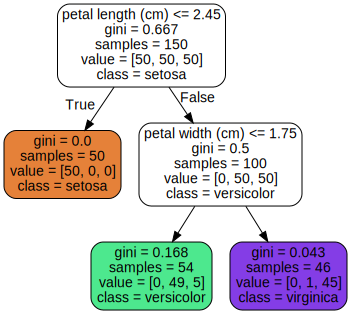

In [7]:
from graphviz import Source

Source.from_file("my_iris_tree.dot")  # path differs in the book

Graphviz also provides the `dot` command line tool to convert `.dot` files to a variety of formats. The following command converts the dot file to a png image:

In [8]:
# extra code
!dot -Tpng "my_iris_tree.dot" -o "my_iris_tree.png"

# Making Predictions

Let's break down the following code cell piece by piece:

**`np.meshgrid()`**: This function is used to create a rectangular grid out of two 1D arrays representing the x and y coordinates. In this code, `np.linspace(0, 7.2, 100)` creates an array of 100 evenly spaced numbers between 0 and 7.2 for **petal length**, and `np.linspace(0, 3, 100)` does the same for **petal width**. `np.meshgrid()` then takes these two 1D arrays and returns two 2D arrays (lengths and widths), which contain the x and y coordinates for all points on a 100x100 grid. This grid covers the entire plotting area for **petal length** and **width**.

**`np.c_[]`**: This is a convenience function in NumPy used for concatenating arrays column-wise. It's equivalent to `np.column_stack()` or `np.concatenate((a, b), axis=1)`. Here, `lengths.ravel()` flattens the lengths 2D array into a 1D array, and `widths.ravel()` does the same for widths. `np.c_[lengths.ravel(), widths.ravel()]` then combines these two flattened 1D arrays into a single 2D array (X_iris_all) where each row represents a coordinate pair `(petal_length, petal_width)` from the grid. This effectively creates a set of all (x,y) points on the grid.

**`plt.contourf()`**: This Matplotlib function draws filled contours. It takes the x and y coordinates of the grid (`lengths`, `widths`) and a corresponding 2D array of values (`y_pred`). In this case, `y_pred` contains the predicted class (0, 1, or 2) for each point on the grid, as determined by the `tree_clf` model. `plt.contourf()` then draws colored regions on the plot, where each color corresponds to a predicted class, effectively visualizing the decision boundaries of the `tree_clf` model. The `alpha=0.3` makes the colors semi-transparent, and `cmap=custom_cmap` specifies the color scheme.



In [9]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))

X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
print(f"{np.linspace(0, 7.2, 100).shape=}, {lengths.shape=}, {widths.shape=}, {lengths.ravel().shape=}, {X_iris_all.shape=}")
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
print(f"{y_pred.shape=}")


np.linspace(0, 7.2, 100).shape=(100,), lengths.shape=(100, 100), widths.shape=(100, 100), lengths.ravel().shape=(10000,), X_iris_all.shape=(10000, 2)
y_pred.shape=(100, 100)


**`zip()`**: This function takes multiple iterables (like lists or tuples) and aggregates them into an iterator of tuples. Each tuple contains elements from the input iterables at the same index. Here, `zip(iris.target_names, ("yo", "bs", "g^"))` pairs each target name (e.g., "setosa", "versicolor", "virginica") with a corresponding plotting style string (e.g., "yo" for yellow circles, "bs" for blue squares, "g^" for green triangles).

**`enumerate()`**: This function adds a counter to an iterable and returns it as an enumerate object. It yields pairs of `(index, item)`. So, `enumerate(zip(...))` gives you `(0, ('setosa', 'yo'))`, then `(1, ('versicolor', 'bs'))`, and so on. In the loop, `idx` gets the index (0, 1, 2 for the three Iris classes) and `name`, `style` get the paired values (e.g., 'setosa', 'yo').
Together, they allow you to easily iterate through both the index (`idx`), the class name (`name`), and the plotting style (`style`) for each Iris species.

**`plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx], style, label=f"Iris {name}")`**: This line, inside the `for` loop, plots the actual training data points. For each Iris class (`idx`), it selects the petal length (`X_iris[:, 0]`) and petal width (`X_iris[:, 1]`) corresponding to that class (`y_iris == idx`) and plots them using the specified style (e.g., yellow circles for Setosa, blue squares for Versicolor, green triangles for Virginica). It also adds a label for the legend.

**`plt.plot([th0, th0], [0, 3], "k-", linewidth=2)`**: This draws a solid black vertical line (`"k-"`) at `x` coordinate `th0`, spanning the y-axis from 0 to 3. This line represents the first decision boundary (Depth=0 split) of the `tree_clf_deeper` model, which splits based on petal length.

**`plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)`**: This draws a dashed black horizontal line (`"k--"`) at `y` coordinate `th1`, starting from `x` coordinate `th0` and extending to `x` coordinate 7.2. This line represents a decision boundary at Depth=1, splitting based on petal width.

**`plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)`**: This draws a dotted black vertical line (`"k:"`) at `x` coordinate `th2a`, spanning the y-axis from 0 to th1. This represents a decision boundary at Depth=2.

**`plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)`**: Similar to the previous line, this draws another dotted black vertical line (`"k:"`) at `x` coordinate `th2b`, spanning the y-axis from `th1` to 3. This also represents a decision boundary at Depth=2.

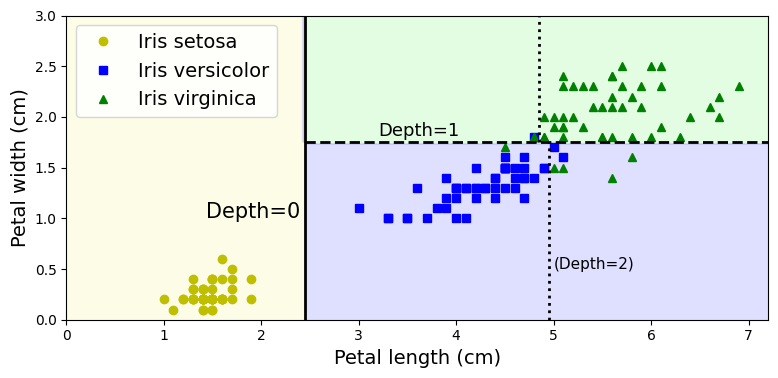

In [10]:
plt.figure(figsize=(8, 4))
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies Figure 5–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries")
plt.show()

In essence, the above two cells first sets up a grid, uses the trained decision tree to predict classifications for all points on that grid, then plots the original data points and overlays the decision boundaries as filled contours and threshold lines, along with text annotations to explain the tree depth at different splits.

You can access the tree structure via the `tree_` attribute:

In [11]:
tree_clf.tree_

For more information, check out this class's documentation:

In [12]:
#help(sklearn.tree._tree.Tree)

See the extra material section below for an example.

# Estimating Class Probabilities

Suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris versicolor (class 1) because it has the highest probability. Let’s check this:

In [13]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [14]:
tree_clf.predict([[5, 1.5]])

array([1])

# Regularization Hyperparameters

We’ll train one decision tree without regularization, and another with min_samples_leaf=5. Here’s the code:

In [15]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

Figure 5-3 shows the decision boundaries of each tree classifiers: one without regularization (`tree_clf1`) and another with `min_samples_leaf=5` (`tree_clf2`).

**`plot_decision_boundary(clf, X, y, axes, cmap) function:`** This is a helper function designed to visualize the decision boundary of a given classifier (`clf`) on a dataset (`X`, `y`).
  - `x1, x2 = np.meshgrid(...) and X_new = np.c_[x1.ravel(), x2.ravel()]`: These lines are similar to the previous explanation.
  - `y_pred = clf.predict(X_new).reshape(x1.shape)`: The provided classifier (`clf`) makes predictions for all the points in the generated grid (`X_new`). These predictions (`y_pred`) are then reshaped back into a 2D grid format to match `x1` and `x2`.
  - `plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)`: This draws filled contours. Each region corresponding to a predicted class is filled with a color from the specified `cmap` (color map), with an alpha (transparency) of 0.3. This visually shows the areas where the classifier predicts different classes.
  - `plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)`: This is a key difference from the earlier example. Instead of just filled regions, this line draws contour lines (unfilled) in shades of grey. These lines explicitly mark the exact boundaries where the classifier's prediction changes from one class to another, making the decision boundaries very clear.
  - `for idx in (0, 1): plt.plot(...)`: This loop iterates through the two classes (0 and 1) in the `moons` dataset. For each class, it plots the original training data points (`X[:, 0][y == idx], X[:, 1][y == idx]`) using the specified color and marker for that class. The `linestyle="none"` ensures only markers are drawn, not lines connecting them.
  - `plt.axis(axes), plt.xlabel(r"$x_1$"), plt.ylabel(r"$x_2$", rotation=0)`: These lines set the limits of the plot, label the x-axis as $x_1$ and the y-axis as $x_2$.

In [16]:
# extra code – this cell generates Figure 5–3

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

**`fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)`**

This line is useful to display multiple plots together. Let's break down each part:

*   **`plt.subplots()`**: This is a powerful Matplotlib function used to create a figure and a set of subplots in a single call. Instead of creating a `Figure` object and then adding `Axes` (subplots) to it separately, `plt.subplots()` streamlines the process.

*   **`fig`**: This variable receives the `Figure` object. The `Figure` is the top-level container for all plot elements. Think of it as the canvas or the entire window where your plots will appear. It can contain one or more `Axes` objects, titles, legends, colorbars, etc.

*   **`axes`**: This variable receives an array (or a single object, depending on the `nrows` and `ncols` arguments) of `Axes` objects. Each `Axes` object represents a single subplot within the figure. It's the region of the figure where the data is actually plotted (e.g., lines, points, bars).

*   **`ncols=2`**: This argument specifies the number of columns for your grid of subplots. Since `nrows` is not explicitly set, it defaults to 1. So, `(nrows=1, ncols=2)` will create a single row with two subplots side-by-side.
    *   **How `ncols` works**: If you had `ncols=1`, `axes` would typically be a 1D array of `Axes` objects (if `nrows > 1`) or just a single `Axes` object (if `nrows=1`). With `ncols=2` (and `nrows=1`), `axes` becomes a 1D NumPy array containing two `Axes` objects, like `[ax0, ax1]`. You can then access these individual subplots as `axes[0]` and `axes[1]` to plot on them.

*   **`figsize=(10, 4)`**: This argument sets the total size of the figure. The first value (10) is the width in inches, and the second value (4) is the height in inches.

*   **`sharey=True`**: This argument ensures that all subplots created by this call will share the same y-axis limits and tick labels. This is particularly useful when you're comparing different plots that have the same y-axis scale, as it makes the comparison easier and prevents redundant labels. If you had multiple rows, `sharex=True` would do the same for the x-axis.

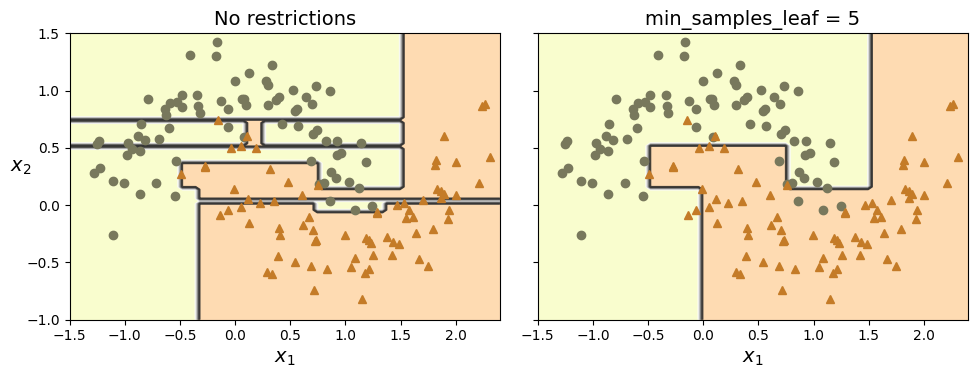

In [17]:
# extra code – this cell generates Figure 5–3 contd.

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("decision_boundaries_unregularized_vs_regularized")
plt.show()

The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better. We can verify this by evaluating both trees on a test set generated using a different random seed:

In [18]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [19]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

# Regression

Let's prepare a simple quadratic training set:

**Code example:**
Let’s build a regression tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quadratic dataset with `max_depth=2`.
This cell prepares a simple quadratic dataset and trains a `DecisionTreeRegressor` on it, setting up the data for regression tasks.

*   **`rng = np.random.default_rng(seed=42)`**:
    *   `np.random.default_rng()` creates a new `Generator` object for generating random numbers. This is the recommended modern approach in NumPy for random number generation, as it is more robust and offers better statistical properties than the older `np.random.RandomState`.
    *   The `seed=42` argument ensures reproducibility. If you run this code multiple times with the same seed, you will get the exact same sequence of random numbers.
    *   The `rng` variable now holds this random number generator instance, which will be used for all subsequent random operations in this cell.

*   **`X_quad = rng.random((200, 1)) - 0.5`**: This line generates 200 random numbers (a single feature) for the input `X`. `rng.random((200, 1))` creates an array of 200 floating-point numbers uniformly distributed between 0.0 and 1.0. Subtracting 0.5 shifts this range to be between -0.5 and 0.5.

*   **`y_quad = X_quad ** 2 + 0.025 * rng.standard_normal((200, 1))`**: This line generates the target values `y`. It defines a quadratic relationship (`X_quad ** 2`) and adds some random noise using `0.025 * rng.standard_normal((200, 1))`. `rng.standard_normal((200, 1))` generates 200 random numbers from a standard normal (Gaussian) distribution, simulating real-world measurement errors or irreducible noise.

*   **`tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)`**: An instance of `DecisionTreeRegressor` is created. `max_depth=2` restricts the tree to a maximum depth of 2 levels.

*   **`tree_reg.fit(X_quad, y_quad)`**: This command trains the `DecisionTreeRegressor` model (`tree_reg`) using the generated input features (`X_quad`) and target values (`y_quad`). The model learns to approximate the quadratic relationship, splitting the data based on the `max_depth` and other default parameters.

In [20]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

rng = np.random.default_rng(seed=42)
X_quad = rng.random((200, 1)) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * rng.standard_normal((200, 1))

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

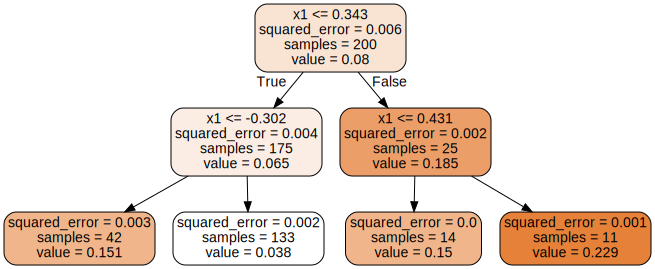

In [21]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg,
    out_file="my_regression_tree.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree.dot")


In [32]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

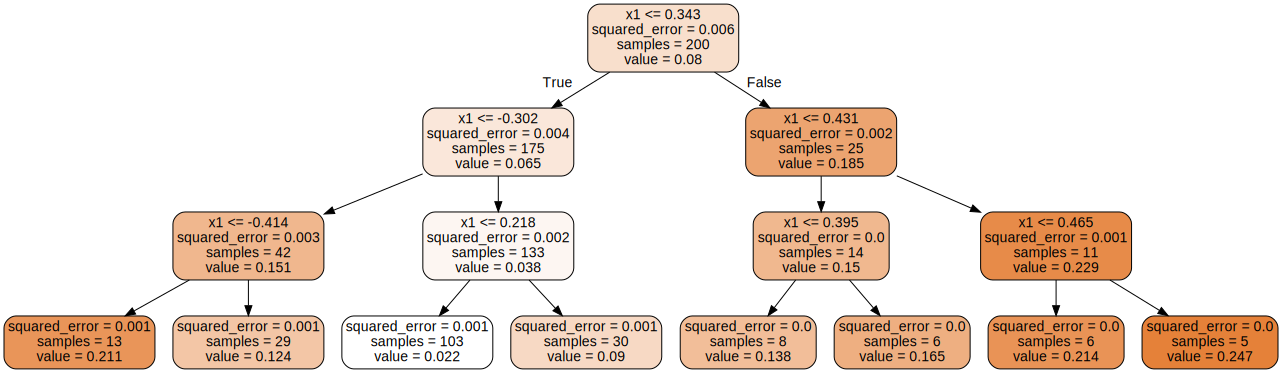

In [33]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg2,
    out_file="my_regression_tree2.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree2.dot")


In [23]:
tree_reg.tree_.threshold

array([ 0.34304063, -0.30182856, -2.        , -2.        ,  0.43140428,
       -2.        , -2.        ])

In [24]:
tree_reg2.tree_.threshold

array([ 0.34304063, -0.30182856, -0.41395289, -2.        , -2.        ,
        0.21817657, -2.        , -2.        ,  0.43140428,  0.39480372,
       -2.        , -2.        ,  0.46470371, -2.        , -2.        ])

This part of the code is responsible for plotting the first subplot (the one with `max_depth=2`) in Figure 5–5, which visualizes the decision tree regression predictions.

*   **`plt.sca(axes[0])`**: `plt.sca()` stands for "set current axes". When you create multiple subplots using `plt.subplots()`, `axes` is typically an array of `Axes` objects. `plt.sca(axes[0])` tells Matplotlib that all subsequent plotting commands (like `plt.plot`, `plt.text`, `plt.title`, etc.) should be applied to the first subplot (`axes[0]`). This allows you to selectively draw on specific subplots.

*   **`plot_regression_predictions(tree_reg, X_quad, y_quad)`**: This line calls the previously defined helper function.

*   **`th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]`**:
    *   `tree_reg.tree_`: Accesses the underlying `Tree` object within the trained `DecisionTreeRegressor` model, which holds the tree's structure and parameters.
    *   `.threshold`: This is an attribute of the `Tree` object that contains the threshold values used at each split node. These thresholds define where the tree makes its decisions.
    *   `[[0, 1, 4]]`: This uses NumPy's advanced indexing to select specific threshold values from the `tree.threshold` array. `0` refers to the threshold of the root node (Depth=0 split), `1` refers to the threshold of the left child at Depth=1, and `4` refers to the threshold of the right child at Depth=1. These selected thresholds are then assigned to `th0`, `th1a`, and `th1b` respectively, representing the main decision boundaries.

*   **`for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):`**: This loop iterates through the calculated thresholds (`th0`, `th1a`, `th1b`) and their corresponding line styles (`"k-"` for solid black, `"k--"` for dashed black). Inside the loop, `plt.plot()` draws vertical lines at these `split` values, representing the decision boundaries learned by the regression tree.

*   **`plt.ylabel("$y$", rotation=0)`**: Sets the label for the y-axis to "y" and prevents it from rotating.

*   **`plt.legend(loc="upper center", fontsize=16)`**: Displays the legend (e.g., for the predicted regression line) at the upper center of the subplot with a specified font size.


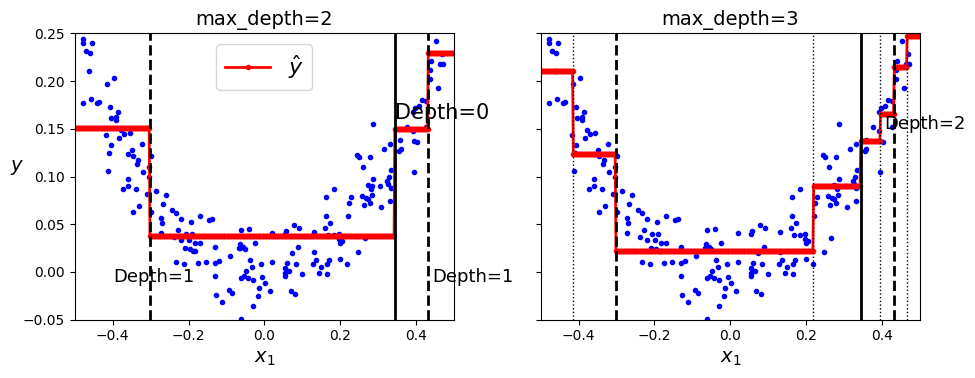

In [25]:
# extra code – this cell generates Figure 5–5

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")
save_fig("decision_tree_regression_predictions")
plt.show()

This cell generates Figure 5–6, which visually compares the predictions of an unregularized `DecisionTreeRegressor` with one that uses the `min_samples_leaf` hyperparameter for regularization.

*   **`tree_reg1 = DecisionTreeRegressor(random_state=42)`**: An unregularized Decision Tree Regressor is instantiated and trained on the `X_quad`, `y_quad` data. This model will likely fit the training data very closely, potentially overfitting.

*   **`tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)`**: A second Decision Tree Regressor is instantiated, but this time with `min_samples_leaf=10`. This hyperparameter restricts the tree, forcing each leaf node to have at least 10 training instances, thereby regularizing the model and making it less prone to overfitting.

*   **`y_pred1 = tree_reg1.predict(x1)` and `y_pred2 = tree_reg2.predict(x1)`**: Both trained models predict values over a fine range of `x1` values (created using `np.linspace`) to generate smooth regression lines.

*   **Plotting**: The cell then sets up two subplots (`fig, axes = plt.subplots(...)`).
    *   The first subplot (`axes[0]`) displays the original data points (`X_quad`, `y_quad`) and the predictions from the unregularized `tree_reg1` (`y_pred1`).
    *   The second subplot (`axes[1]`) also shows the original data and the predictions from the regularized `tree_reg2` (`y_pred2`).
    *   This visual comparison highlights how `min_samples_leaf` creates a smoother, more generalized regression curve by preventing the tree from making overly complex splits to fit individual data points.

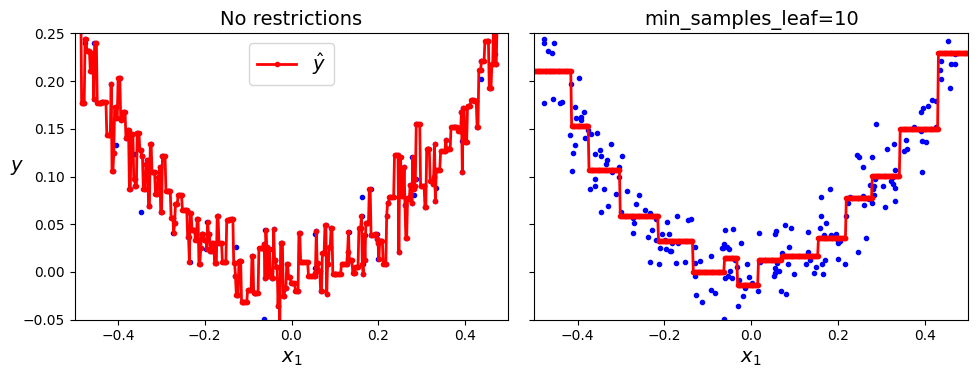

In [26]:
# extra code – this cell generates Figure 5–6

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")
save_fig("tree_predictions_unregularized_vs_regularized")
plt.show()

In [43]:
print(f"{tree_reg1.tree_.max_depth=}, {tree_reg2.tree_.max_depth=}")

tree_reg1.tree_.max_depth=17, tree_reg2.tree_.max_depth=3


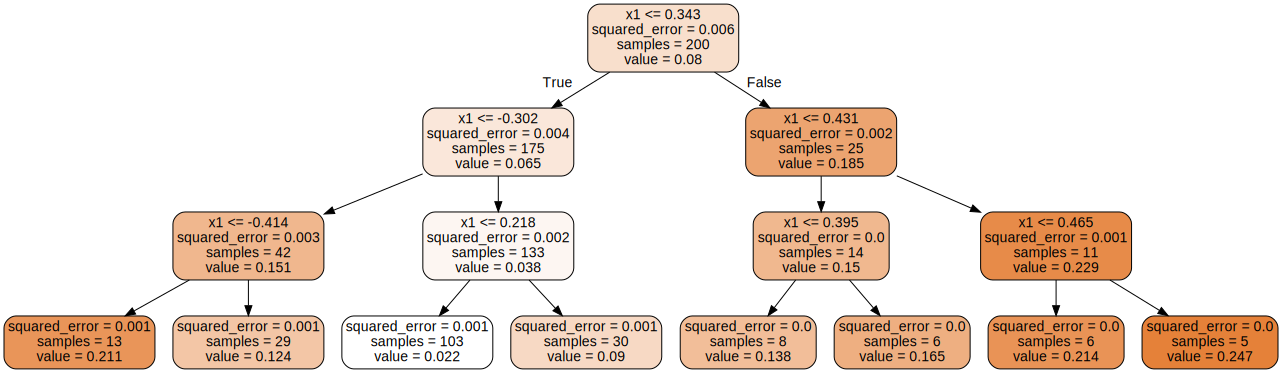

In [39]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg2,
    out_file="my_regression_tree2.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree2.dot")


# Sensitivity to axis orientation

This cell generates Figure 5–7, which visually demonstrates the **sensitivity of Decision Trees to axis orientation**.

*   **`rng = np.random.default_rng(seed=42)`**: Initializes a random number generator for reproducibility.

*   **`X_square = rng.random((100, 2)) - 0.5`**: Creates a dataset `X_square` of 100 2D points, uniformly distributed in a square ranging from -0.5 to 0.5 for both features.

*   **`y_square = (X_square[:, 0] > 0).astype(np.int64)`**: Assigns labels `y_square` based on whether the first feature (x-coordinate) is positive or not, effectively creating two classes separated by a vertical line at x=0.

*   **`angle = np.pi / 4`**: Defines an angle of 45 degrees (π/4 radians) for rotation.

*   **`rotation_matrix = np.array(...)`**: Constructs a 2D rotation matrix for rotating points by the specified `angle`.

*   **`X_rotated_square = X_square.dot(rotation_matrix)`**: Applies the rotation matrix to the `X_square` dataset, creating a new dataset `X_rotated_square` that is the rotated version of the original.

*   **`tree_clf_square = DecisionTreeClassifier(...)` and `tree_clf_rotated_square = DecisionTreeClassifier(...)`**: Two `DecisionTreeClassifier` models are created. `tree_clf_square` is trained on the original `X_square` data, while `tree_clf_rotated_square` is trained on the `X_rotated_square` data. Both use `random_state=42` for reproducibility.

*   **Plotting**: Two subplots are created using `fig, axes = plt.subplots(...)`. The `plot_decision_boundary` function (explained previously) is called for each tree:
    *   `plt.sca(axes[0])` plots the decision boundary of `tree_clf_square` on the original data.
    *   `plt.sca(axes[1])` plots the decision boundary of `tree_clf_rotated_square` on the rotated data.

This visual comparison clearly shows how a simple rotation of the input data can lead to a completely different decision tree structure and boundaries, highlighting a limitation of decision trees.

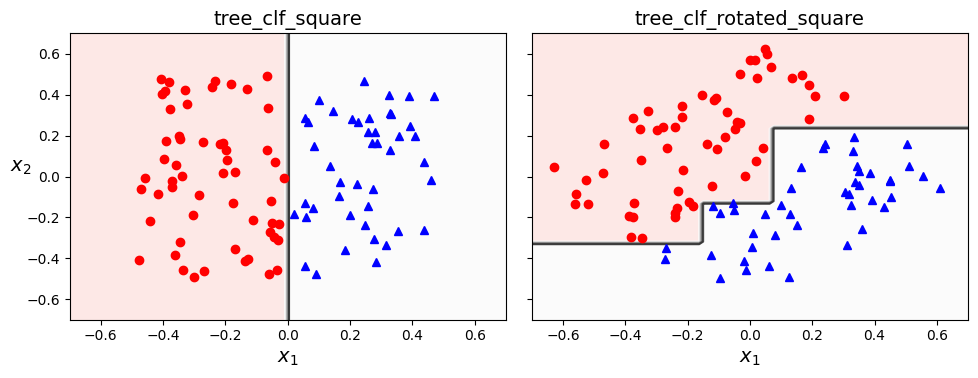

In [27]:
# extra code – this cell generates Figure 5–7

rng = np.random.default_rng(seed=42)
X_square = rng.random((100, 2)) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.title("tree_clf_square")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")
plt.title("tree_clf_rotated_square")
save_fig("sensitivity_to_traning_set_rotation")
plt.show()

In [50]:
print(f"{tree_clf_square.tree_.max_depth=}, {tree_clf_rotated_square.tree_.max_depth=}")

tree_clf_square.tree_.max_depth=1, tree_clf_rotated_square.tree_.max_depth=4


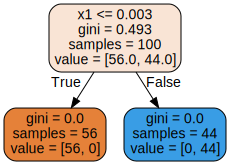

In [51]:
# extra code
export_graphviz(
    tree_clf_square,
    out_file="my_regression_tree3.dot",
    feature_names=["x1", "x2"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree3.dot")


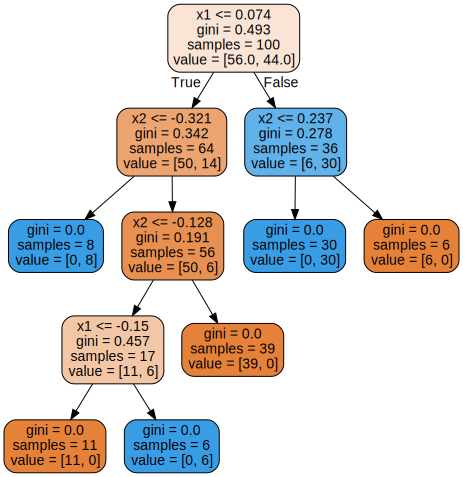

In [48]:
# extra code
export_graphviz(
    tree_clf_rotated_square,
    out_file="my_regression_tree3.dot",
    feature_names=["x1", "x2"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree3.dot")


This cell demonstrates how Principal Component Analysis (PCA) can be used to preprocess data before training a Decision Tree, potentially addressing the sensitivity of Decision Trees to axis orientation.

*   **`pca_pipeline = make_pipeline(StandardScaler(), PCA())`**: Creates a pipeline named `pca_pipeline`. This pipeline first standardizes the input data using `StandardScaler`, and then applies PCA to the standardized data.

*   **`X_iris_rotated = pca_pipeline.fit_transform(X_iris)`**: Applies the `pca_pipeline` to the `X_iris` dataset. `fit_transform` first learns the scaling parameters and PCA components from `X_iris` (fit) and then transforms `X_iris` into the new PCA-transformed space (`transform`). The result, `X_iris_rotated`, is the original Iris data projected onto its principal components.

*   **`tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)`**: Instantiates a `DecisionTreeClassifier` with a maximum depth of 2, set for reproducibility.

*   **`tree_clf_pca.fit(X_iris_rotated, y_iris)`**: Trains this Decision Tree classifier on the `X_iris_rotated` data (the PCA-transformed features) and the original `y_iris` target labels.

In [53]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

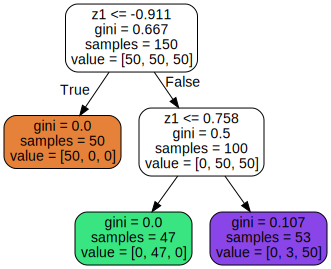

In [55]:
# extra code
export_graphviz(
    tree_clf_pca,
    out_file="my_regression_tree3.dot",
    feature_names=["z1", "z2"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree3.dot")


This cell generates Figure 5–8, which visualizes the decision boundaries of the `DecisionTreeClassifier` (`tree_clf_pca`) trained on the PCA-transformed Iris dataset (`X_iris_rotated`).

*   **`z0s, z1s = np.meshgrid(...)` and `X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]`**: These lines create a grid of points covering the plotting area, but this time in the PCA-transformed space, where the axes are `z1` and `z2` (the principal components).

*   **`y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)`**: Uses the Decision Tree trained on PCA data (`tree_clf_pca`) to predict the class for each point on the PCA grid. The predictions are then reshaped to match the grid dimensions.

*   **`plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)`**: Draws filled contours representing the decision regions of the `tree_clf_pca` in the `z1` and `z2` space, using the previously defined `custom_cmap`.

*   **`for idx, (name, style) in enumerate(zip(iris.target_names, (...)))`**: This loop plots the actual PCA-transformed Iris data points (`X_iris_rotated`) for each class, using distinct styles (yellow circles, blue squares, green triangles) to differentiate them.

*   **`plt.xlabel("$z_1$")` and `plt.ylabel("$z_2$", rotation=0)`**: Labels the x and y axes as `z1` and `z2` to indicate they represent the first and second principal components.

*   **`th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]`**: Extracts the thresholds for the root node (Depth=0) and one of its child nodes (Depth=1) from the `tree_clf_pca` model's internal tree structure.

*   **`plt.plot(...)` and `plt.text(...)`**: These lines draw vertical lines at the extracted thresholds (`th1`, `th2`) and add text annotations to label them as "Depth=0" and "Depth=1", visually explaining the tree's splitting decisions in the PCA space.


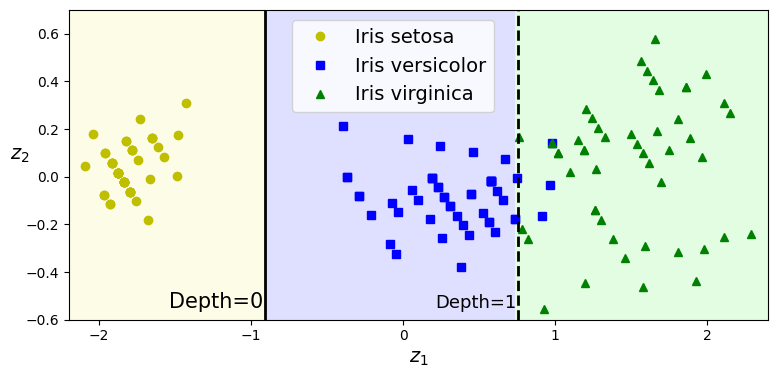

In [56]:
# extra code – this cell generates Figure 5–8

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
save_fig("PCA_rotated_iris_tree_classification")
plt.show()

# Decision Trees Have High Variance

We've seen that small changes in the dataset (such as a rotation) may produce a very different Decision Tree.
Now let's show that training the same model on the same data may produce a very different model every time, since the CART training algorithm used by Scikit-Learn is stochastic. To show this, we will set `random_state` to a different value than earlier:

In [60]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

This cell generates Figure 5–9, which visually demonstrates the high variance of Decision Trees.

*   **`y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)`**: Predicts class labels for the entire grid using `tree_clf_tweaked`, which was trained with a different `random_state` (40) compared to the original `tree_clf` (42).

*   **`plt.contourf(...)`**: Draws filled contours representing the decision boundaries of this newly trained tree.

*   **`for idx, (name, style) in enumerate(zip(...))`**: Plots the original Iris data points, similar to previous visualizations.

*   **`th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]`**: Extracts the thresholds for the root node (Depth=0) and its left child (Depth=1) from `tree_clf_tweaked`.

*   **`plt.plot(...)` and `plt.text(...)`**: Draws horizontal lines at these thresholds and adds text annotations for "Depth=0" and "Depth=1". Notice that these decision boundaries are different from the ones generated by the `tree_clf_deeper` in the initial visualization, even though the data is the same, illustrating the sensitivity to `random_state`.

*   **`plt.xlabel(...)`, `plt.ylabel(...)`, `plt.axis(...)`, `plt.legend()`**: Sets axis labels, plot limits, and displays the legend.


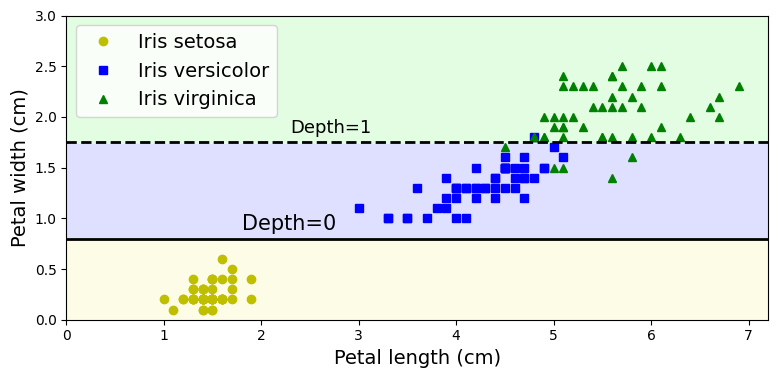

In [61]:
# extra code – this cell generates Figure 5–9

plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("retrain_same_model_on_different_random_state")
plt.show()

# Extra Material – Accessing the tree structure

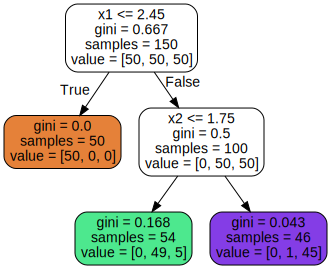

In [70]:
# extra code
export_graphviz(
    tree_clf,
    out_file="my_regression_tree.dot",
    feature_names=["x1","x2"],
    rounded=True,
    filled=True
)
#save_fig("my_regression_tree.dot")
Source.from_file("my_regression_tree.dot")


A trained `DecisionTreeClassifier` has a `tree_` attribute that stores the tree's structure:

In [62]:
tree = tree_clf.tree_
tree

You can get the total number of nodes in the tree:

In [63]:
tree.node_count

5

And other self-explanatory attributes are available:

In [64]:
tree.max_depth

2

In [65]:
tree.max_n_classes

3

In [66]:
tree.n_features

2

In [67]:
tree.n_outputs

1

In [68]:
tree.n_leaves

np.int64(3)

All the information about the nodes is stored in NumPy arrays. For example, the impurity of each node:

In [71]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node _i_ are `tree.children_left[i]` and `tree.children_right[i]`. For example, the children of the root node are:

In [72]:
tree.children_left[0], tree.children_right[0]

(np.int64(1), np.int64(2))

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [73]:
tree.children_left[3], tree.children_right[3]

(np.int64(-1), np.int64(-1))

So you can get the leaf node ids like this:
This cell provides a method to identify and retrieve the indices of all leaf nodes within the decision tree's structure.

*   **`is_leaf = (tree.children_left == tree.children_right)`**:
    
    *   This line performs an element-wise comparison. It creates a boolean NumPy array named `is_leaf`. An element in `is_leaf` will be `True` if the corresponding node's left and right child indices are equal (indicating it's a leaf node), and `False` otherwise (indicating it's a split node).

*   **`np.arange(tree.node_count)`**:
    *   `tree.node_count` is an attribute of the `Tree` object that gives the total number of nodes in the decision tree.
    *   `np.arange()` is a NumPy function that returns an array with evenly spaced values within a given interval. In this case, `np.arange(tree.node_count)` generates a NumPy array containing integers from `0` up to (but not including) `tree.node_count`. This array effectively represents all possible node indices in the tree (e.g., `[0, 1, 2, 3, 4]` if there are 5 nodes).

*   **`np.arange(tree.node_count)[is_leaf]`**: This final part uses boolean indexing. It takes the array of all node indices generated by `np.arange()` and filters it using the `is_leaf` boolean array. Only the node indices where `is_leaf` is `True` (i.e., the indices of the leaf nodes) are selected and returned in a new array.

In [74]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called _split nodes_. The feature they split is available via the `feature` array. Values for leaf nodes should be ignored:

In [75]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [76]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [77]:
tree.value

array([[[0.33333333, 0.33333333, 0.33333333]],

       [[1.        , 0.        , 0.        ]],

       [[0.        , 0.5       , 0.5       ]],

       [[0.        , 0.90740741, 0.09259259]],

       [[0.        , 0.02173913, 0.97826087]]])

In [78]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [79]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

np.False_

Here's how you can compute the depth of each node:

In [80]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here's how to get the thresholds of all split nodes at depth 1:

In [81]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [82]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])

# Exercise solutions

## 1. to 6.

1. The depth of a well-balanced binary tree containing _m_ leaves is equal to log₂(_m_), rounded up. log₂ is the binary log; log₂(_m_) = log(_m_) / log(2). A binary Decision Tree (one that makes only binary decisions, as is the case with all trees in Scikit-Learn) will end up more or less well balanced at the end of training, with one leaf per training instance if it is trained without restrictions. Thus, if the training set contains one million instances, the Decision Tree will have a depth of log₂(10<sup>6</sup>) ≈ 20 (actually a bit more since the tree will generally not be perfectly well balanced).
2. A node's Gini impurity is generally lower than its parent's. This is due to the CART training algorithm's cost function, which splits each node in a way that minimizes the weighted sum of its children's Gini impurities. However, it is possible for a node to have a higher Gini impurity than its parent, as long as this increase is more than compensated for by a decrease in the other child's impurity. For example, consider a node containing four instances of class A and one of class B. Its Gini impurity is 1 – (1/5)² – (4/5)² = 0.32. Now suppose the dataset is one-dimensional and the instances are lined up in the following order: A, B, A, A, A. You can verify that the algorithm will split this node after the second instance, producing one child node with instances A, B, and the other child node with instances A, A, A. The first child node's Gini impurity is 1 – (1/2)² – (1/2)² = 0.5, which is higher than its parent's. This is compensated for by the fact that the other node is pure, so its overall weighted Gini impurity is 2/5 × 0.5 + 3/5 × 0 = 0.2, which is lower than the parent's Gini impurity.
3. If a Decision Tree is overfitting the training set, it may be a good idea to decrease `max_depth`, since this will constrain the model, regularizing it.
4. Decision Trees don't care whether or not the training data is scaled or centered; that's one of the nice things about them. So if a Decision Tree underfits the training set, scaling the input features will just be a waste of time.
5. The computational complexity of training a Decision Tree is _O_(_n_ × _m_ log₂(_m_)). So if you multiply the training set size by 10, the training time will be multiplied by _K_ = (_n_ × 10 _m_ × log₂(10 _m_)) / (_n_ × _m_ × log₂(_m_)) = 10 × log₂(10 _m_) / log₂(_m_). If _m_ = 10<sup>6</sup>, then _K_ ≈ 11.7, so you can expect the training time to be roughly 11.7 hours.
6. If the number of features doubles, then the training time will also roughly double.

## 7.

_Exercise: train and fine-tune a Decision Tree for the moons dataset._

a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [83]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. Split it into a training set and a test set using `train_test_split()`.

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons,
                                                    test_size=0.2,
                                                    random_state=42)

c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [85]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': [1, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4]
}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              params,
                              cv=3)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [86]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, random_state=42)

d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [87]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

## 8.

_Exercise: Grow a forest._

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [88]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances,
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [89]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)

    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

np.float64(0.8056605)

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [90]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [91]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [92]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873